# **TECHNICAL ANALYSIS + CNN**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from stockstats import StockDataFrame

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA, GOOG

/usr/local/lib/python3.7/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


In [ ]:
#Plot configs
plt.rcParams['figure.figsize'] = (10,5)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## **OBTENDO OS DADOS**

In [ ]:
company = 'GOOG'
df = GOOG[:int(len(GOOG)*.7)]
df.rename(columns={col: col.lower() for col in df.columns}, inplace=True)

print(df.shape)
df.head()

(1503, 5)


,open,high,low,close,volume
2004-08-19,100.00,104.06,95.96,100.34,22351900
2004-08-20,101.01,109.08,100.50,108.31,11428600
2004-08-23,110.75,113.48,109.05,109.40,9137200
2004-08-24,111.24,111.60,103.57,104.87,7631300
2004-08-25,104.96,108.00,103.88,106.00,4598900


In [ ]:
df_test = GOOG[int(len(GOOG)*.7):]
df_test.rename(columns={col: col.lower() for col in df_test.columns}, inplace=True)

actual_prices = df_test['close'].values
total_dataset = pd.concat((df['close'], df_test['close']), axis=0)

## **Base de indicadores técnicos**

In [ ]:
sdf = StockDataFrame(df.copy())

sma10 = sdf['close_10_sma']
sma20 = sdf['close_20_sma']
ema20 = sdf['close_20_ema']
cci14 = sdf['cci_14']
rsi11 = sdf['rsi_11']

sdf.head()

,open,high,low,close,volume,close_10_sma,close_20_sma,close_20_ema,cci_14,rs_11,rsi_11
2004-08-19,100.00,104.06,95.96,100.34,22351900,100.340000,100.340000,100.340000,NaN,NaN,NaN
2004-08-20,101.01,109.08,100.50,108.31,11428600,104.325000,104.325000,104.524250,66.666667,inf,100.000000
2004-08-23,110.75,113.48,109.05,109.40,9137200,106.016667,106.016667,106.314596,92.892057,inf,100.000000
2004-08-24,111.24,111.60,103.57,104.87,7631300,105.730000,105.730000,105.897564,19.269167,1.672778,62.585749
2004-08-25,104.96,108.00,103.88,106.00,4598900,105.784000,105.784000,105.922342,2.510622,1.947171,66.069159


## **PREPARAÇÃO DOS DADOS**

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1,1))

In [ ]:
prediction_days = 80

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])

In [ ]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## **CRIANDO O MODELO**

In [ ]:
model = Sequential()

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=80, batch_size=80)

Epoch 1/80
18/18 [==============================] - 2s 71ms/step - loss: 0.0385
Epoch 2/80
18/18 [==============================] - 2s 115ms/step - loss: 0.0074
Epoch 3/80
18/18 [==============================] - 2s 135ms/step - loss: 0.0056
Epoch 4/80
18/18 [==============================] - 2s 136ms/step - loss: 0.0039
Epoch 5/80
18/18 [==============================] - 2s 138ms/step - loss: 0.0030
Epoch 6/80
18/18 [==============================] - 2s 118ms/step - loss: 0.0025
Epoch 7/80
18/18 [==============================] - 2s 123ms/step - loss: 0.0025
Epoch 8/80
18/18 [==============================] - 3s 157ms/step - loss: 0.0021
Epoch 9/80
18/18 [==============================] - 3s 160ms/step - loss: 0.0016
Epoch 10/80
18/18 [==============================] - 3s 147ms/step - loss: 0.0015
Epoch 11/80
18/18 [==============================] - 3s 153ms/step - loss: 0.0015
Epoch 12/80
18/18 [==============================] - 2s 129ms/step - loss: 0.0012
Epoch 13/80
18/18 [=======

In [ ]:
model_inputs= total_dataset[len(total_dataset) - len(df_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days: x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

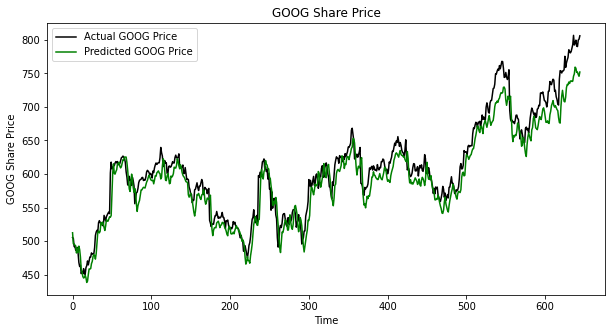

In [ ]:
plt.plot(actual_prices, color='black', label= f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label= f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend([f'Actual {company} Price', f'Predicted {company} Price'])
plt.show()

In [ ]:
print(mean_squared_error(actual_prices, predicted_prices))
print(r2_score(actual_prices, predicted_prices))

516.2854577059348
0.9047344640189852
